This notebook downloads BOSS DR10 p(z) data and formats it for use by ZPDFTW code.
It currently lacks the calculation of the interim prior on N(z) used to produce the p(z) data so a flat interim prior is substituted here.  This is not valid for calculations!

In [20]:
import requests
import numpy as np
import csv
import re
import os
import sys
import pyfits
import random
import matplotlib.pyplot as plt
%matplotlib inline

colors = 'rgbcmy'

In [2]:
def safelog(xarr):
    """
    safelog takes log of array with zeroes
    """
    shape = np.shape(xarr)
    flat = xarr.flatten()
    logged = np.log(np.array([max(x,sys.float_info.epsilon) for x in flat]))
    return logged.reshape(shape)

In [4]:
with pyfits.open("http://data.sdss3.org/sas/dr10/boss/photoObj/photoz-weight/zbins-12.fits") as Zbins:
    Zlos = np.array([Zbins[1].data[i][0] for i in range(0,len(Zbins[1].data))])
    Zhis = np.array([Zbins[1].data[i][1] for i in range(0,len(Zbins[1].data))])
allZs = np.unique(np.concatenate((Zlos,Zhis)))
Zdifs = Zhis-Zlos
nbins = len(allZs-1)

In [5]:
data = requests.get('http://data.sdss3.org/sas/dr10/boss/photoObj/photoz-weight/')
formatted = data.content
lines = formatted.split('\n')
plantest = [str.split(line) for line in lines]

sizes = np.array([int(plantest[::2][i][4]) for i in range(3,562)])
names = np.array([plantest[::2][i][1][6:28] for i in range(3,562)])

In [6]:
address = names[np.argmin(sizes)]
topdir = 'http://data.sdss3.org/sas/dr8/groups/boss/photoObj/photoz-weight/'
link = topdir+address
pZtest = pyfits.open(link)
pZtest[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  203 / length of dimension 1                          
NAXIS2  =                    1 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   14 / number of table fields                         
TTYPE1  = 'objid   '                                                            
TFORM1  = 'K       '                                                            
TTYPE2  = 'run     '                                                            
TFORM2  = 'J       '                                                            
TTYPE3  = 'rerun   '        

In [42]:
import urllib2

#mags = []
pZdists = []
topdir = 'http://data.sdss3.org/sas/dr8/groups/boss/photoObj/photoz-weight/'
for i in xrange(len(names)):
    address = names[i]
    size = sizes[i]
    if size < 100000:# comment this out if using
        link = topdir+address
        with pyfits.open(link) as pZtest:
            data = pZtest[1].data
            for j in xrange(len(data)):
                #if data[j][8] < 20:
                pZdists.append(data[j][13])
                    #mags.append(data[j][8])
#mags = np.array(mags)
pZdists = np.array(pZdists)
logpZdists = safelog(pZdists)
ngals = len(pZdists)
print(ngals)

18133


20.4789
20.6707


(array([   4.,    6.,   13.,   29.,   62.,   98.,  192.,  298.,  396.,  396.]),
 array([ 15.90144348,  16.49125977,  17.08107605,  17.67089233,
         18.26070862,  18.8505249 ,  19.44034119,  20.03015747,
         20.61997375,  21.20979004,  21.79960632]),
 <a list of 10 Patch objects>)

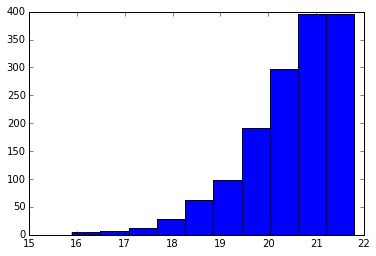

In [32]:
print(np.mean(mags))
print(np.median(mags))
plt.hist(mags)

zmin    zmax    N(z)    sigma
0.000 	0.031 	0.150 	0.052
0.031 	0.063 	0.822 	0.215
0.063 	0.094 	1.837 	0.409
0.094 	0.126 	2.815 	0.503
0.126 	0.157 	3.909 	0.509
0.157 	0.189 	5.116 	0.725
0.189 	0.220 	6.065 	0.905
0.220 	0.251 	6.477 	0.767
0.251 	0.283 	6.834 	0.817
0.283 	0.314 	7.304 	0.868
0.314 	0.346 	7.068 	0.645
0.346 	0.377 	6.771 	0.785
0.377 	0.409 	6.587 	0.609
0.409 	0.440 	6.089 	0.627
0.440 	0.471 	5.165 	0.602
0.471 	0.503 	4.792 	0.522
0.503 	0.534 	4.228 	0.383
0.534 	0.566 	3.664 	0.394
0.566 	0.597 	3.078 	0.364
0.597 	0.629 	2.604 	0.275
0.629 	0.660 	2.130 	0.224
0.660 	0.691 	1.683 	0.191
0.691 	0.723 	1.348 	0.156
0.723 	0.754 	0.977 	0.141
0.754 	0.786 	0.703 	0.102
0.786 	0.817 	0.521 	0.080
0.817 	0.849 	0.339 	0.060
0.849 	0.880 	0.283 	0.048
0.880 	0.911 	0.187 	0.037
0.911 	0.943 	0.141 	0.031
0.943 	0.974 	0.104 	0.027
0.974 	1.006 	0.081 	0.020
1.006 	1.037 	0.055 	0.017
1.037 	1.069 	0.043 	0.015
1.069 	1.100 	0.034 	0.012

In [43]:
intprior = np.array([0.150,0.822,1.837,2.815,3.909,5.116,6.065,6.477,6.834,7.304,7.068,6.771,6.587,6.089,5.165,4.729,
                     4.228,3.664,3.078,2.604,2.130,1.683,1.348,0.977,0.703,0.521,0.339,0.283,0.187,0.141,0.104,0.081,
                     0.055,0.043,0.034])
intprior = ngals*intprior/np.dot(Zdifs,intprior)
logintprior = safelog(intprior)

In [45]:
with open('tests/data-test/data/logdata.csv', 'wb') as csvfile:
    pZwriter = csv.writer(csvfile, delimiter=' ')
    pZwriter.writerow(allZs)
    pZwriter.writerow(logintprior)
    pZwriter.writerows(logpZdists)

plt.title('Randomly sampled redshift distributions')
randgals = random.sample(xrange(ngals),6)
for j in xrange(6):#randgals:
    plt.hlines(pZdists[randgals[j]],Zlos,Zhis,color=colors[j%6])
    plt.vlines(allZs[1:-1],pZdists[randgals[j]][:-1],pZdists[randgals[j]][1:],color=colors[j%6])
plt.show()